In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from transformers import pipeline

from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/lib/kaggle/gcp.py
/kaggle/input/customer-support-ticket-dataset/customer_support_tickets.csv


In [2]:
df = pd.read_csv('/kaggle/input/customer-support-ticket-dataset/customer_support_tickets.csv')

# Drop rows with missing values (inplace=False by default, so it doesn't modify df in place)
df.dropna()


# Rename certain columns for consistency and easier access
df.rename(columns={'Ticket Status': 'Ticket_Status', 'Customer Gender': 'Customer_Gender', 
                   'Ticket Priority': 'Ticket_Priority', 'Ticket Type': 'Ticket_Type'}, inplace=True)

In [3]:
df.head(1).T

,0
Ticket ID,1
Customer Name,Marisa Obrien
Customer Email,carrollallison@example.com
Customer Age,32
Customer_Gender,Other
Product Purchased,GoPro Hero
Date of Purchase,2021-03-22
Ticket_Type,Technical issue
Ticket Subject,Product setup
Ticket Description,I'm having an issue with the {product_purchase...


In [4]:
df['Ticket Description'] = df.apply(lambda row: row['Ticket Description'].replace('{product_purchased}', row['Product Purchased']), axis=1)

<Axes: title={'center': 'Value Counts of Ticket Type'}, xlabel='Ticket Type', ylabel='Count'>

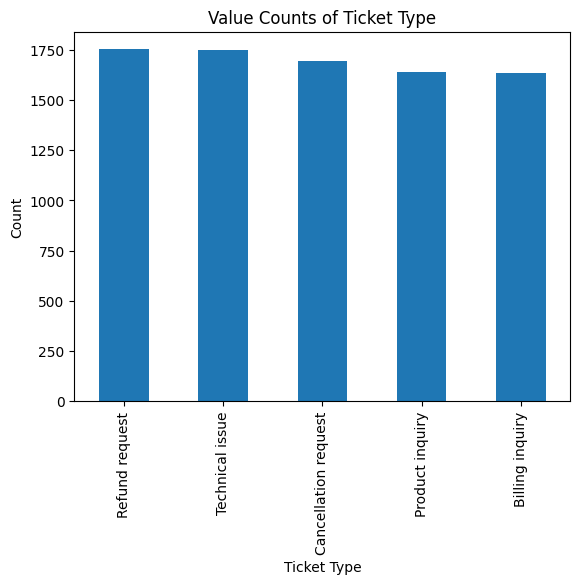

In [5]:
df["Ticket_Type"].value_counts().plot(kind='bar', title='Value Counts of Ticket Type', xlabel='Ticket Type', ylabel='Count')

In [6]:
labels = df["Ticket_Type"].unique()
labels

array(['Technical issue', 'Billing inquiry', 'Cancellation request',
       'Product inquiry', 'Refund request'], dtype=object)

In [9]:
df["Description Size"] = df["Ticket Description"].str.len()

<Axes: title={'center': 'The Sizes of ticket description'}, xlabel='Ticket description Size', ylabel='Count'>

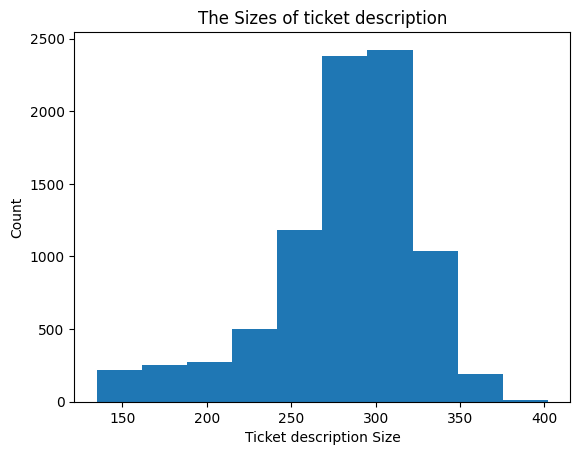

In [14]:
df["Description Size"].plot.hist(title='The Sizes of ticket description', xlabel='Ticket description Size', ylabel='Count')

In [15]:
df.head()

,Ticket ID,Customer Name,Customer Email,Customer Age,Customer_Gender,Product Purchased,Date of Purchase,Ticket_Type,Ticket Subject,Ticket Description,Ticket_Status,Resolution,Ticket_Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating,Description Size
0,1,Marisa Obrien,carrollallison@example.com,32,Other,GoPro Hero,2021-03-22,Technical issue,Product setup,I'm having an issue with the GoPro Hero. Pleas...,Pending Customer Response,NaN,Critical,Social media,2023-06-01 12:15:36,NaN,NaN,275
1,2,Jessica Rios,clarkeashley@example.com,42,Female,LG Smart TV,2021-05-22,Technical issue,Peripheral compatibility,I'm having an issue with the LG Smart TV. Plea...,Pending Customer Response,NaN,Critical,Chat,2023-06-01 16:45:38,NaN,NaN,266
2,3,Christopher Robbins,gonzalestracy@example.com,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,I'm facing a problem with my Dell XPS. The Del...,Closed,Case maybe show recently my computer follow.,Low,Social media,2023-06-01 11:14:38,2023-06-01 18:05:38,3.0,242
3,4,Christina Dillon,bradleyolson@example.org,27,Female,Microsoft Office,2020-11-13,Billing inquiry,Account access,I'm having an issue with the Microsoft Office....,Closed,Try capital clearly never color toward story.,Low,Social media,2023-06-01 07:29:40,2023-06-01 01:57:40,3.0,259
4,5,Alexander Carroll,bradleymark@example.com,67,Female,Autodesk AutoCAD,2020-02-04,Billing inquiry,Data loss,I'm having an issue with the Autodesk AutoCAD....,Closed,West decision evidence bit.,Low,Email,2023-06-01 00:12:42,2023-06-01 19:53:42,1.0,327


# Text preprocessing
- Padding 350 words
- Do pre padding if im using an lstm
- Do lemmatization
- remove stopwords,special characters
- lower case
- Handling StopWords


In [32]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

# Download necessary NLTK data files
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet',download_dir = "/kaggle/input/customer-support-ticket-dataset")


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /kaggle/input/customer-
[nltk_data]     support-ticket-dataset...


OSError: [Errno 30] Read-only file system: '/kaggle/input/customer-support-ticket-dataset/corpora'

In [29]:
# import these modules
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

print("rocks :", lemmatizer.lemmatize("rocks"))
print("corpora :", lemmatizer.lemmatize("corpora"))

# a denotes adjective in "pos"
print("better :", lemmatizer.lemmatize("better", pos="a"))


LookupError: 
**********************************************************************
  Resource 'corpora/wordnet' not found.  Please use the NLTK
  Downloader to obtain the resource:  >>> nltk.download()
  Searched in:
    - '/root/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************

In [25]:

def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize text
    tokens = word_tokenize(text)
    
    # Initialize lemmatizer and stopwords
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    
    # Remove stopwords and perform lemmatization
    processed_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    
    # Join tokens back into a single string
    processed_text = ' '.join(processed_tokens)
    
    return processed_text


In [26]:
preprocess_text(df["Ticket Description"].loc[0])

LookupError: 
**********************************************************************
  Resource 'corpora/wordnet' not found.  Please use the NLTK
  Downloader to obtain the resource:  >>> nltk.download()
  Searched in:
    - '/root/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************

In [ ]:
model="google-bert/bert-base-uncased"

In [ ]:
pipe = pipeline("zero-shot-classification", model)

# Zero shot prompting

## 4 out 5 are correct but the scores have minute difference in their decisions

#### Sample

In [ ]:
inference_sample_ip = df["Ticket Description"].iloc[:5].tolist()
inference_sample_op = pipe(inference_sample_ip,labels, multi_label=True, return_all_scores = False)

In [ ]:
inference_sample_op

In [ ]:
[op['labels'][0] for op in inference_sample_op]

#### Sample Data

In [ ]:
sample_len = 10 
sampled_df = df.groupby('Ticket_Type', group_keys=False).apply(lambda x: x.sample(n=min(len(x), sample_len), replace=False)).reset_index(drop=True)

In [ ]:
sampled_df["Ticket_Type"].value_counts().plot(kind='bar', title='Value Counts of Ticket Type', xlabel='Ticket Type', ylabel='Count')

In [ ]:
from sklearn.model_selection import train_test_split

def create_train_test_split(df, test_size=0.2):
    """
    Splits the input DataFrame into train and test datasets with equal distribution of each Ticket_Type.

    Args:
    df (pd.DataFrame): Input DataFrame containing 'Ticket ID', 'Ticket Description', and 'Ticket_Type'.
    test_size (float): Proportion of the dataset to include in the test split.

    Returns:
    train_dataset (Dataset): Training dataset.
    test_dataset (Dataset): Testing dataset.
    """
    # Perform stratified train-test split
    train_df, test_df = train_test_split(df[['Ticket Description','Ticket_Type']], test_size=test_size, stratify=df['Ticket_Type'])

    # Convert the split data back to Hugging Face datasets
    train_dataset = Dataset.from_pandas(train_df)
    test_dataset = Dataset.from_pandas(test_df)

    train_dataset = train_dataset.rename_column("Ticket Description", "text")
    train_dataset = train_dataset.rename_column("Ticket_Type", "label")

    test_dataset = test_dataset.rename_column("Ticket Description", "text")
    test_dataset = test_dataset.rename_column("Ticket_Type", "label")

    return train_dataset, test_dataset

In [ ]:
from torch.utils.data import Dataset

class ListDataset(Dataset):
     def __init__(self, original_list):
        self.original_list = original_list
     def __len__(self):
        return len(self.original_list)

     def __getitem__(self, i):
        return self.original_list[i]

In [ ]:
text_data = ListDataset(sampled_df["Ticket Description"].tolist())
text_data

In [ ]:
sampled_df.head()

In [ ]:

def calculate_accuracy(df,ip_data):
    # Initialize lists to store true labels and predicted labels
    true_labels = df.Ticket_Type.tolist()
    predictions = []
    for pred in tqdm(pipe(ip_data,labels, multi_label=True,do_sample=True,
    top_k=10)):
        predictions.append(pred)
    predicted_labels = [op['labels'][0] for op in predictions]
    print(true_labels, predicted_labels)
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)
    
    return accuracy

In [ ]:
accuracy_sample = calculate_accuracy(sampled_df, text_data)

In [ ]:
accuracy_sample

# Few shot learnings

In [ ]:
!pip install setfit

In [ ]:
from datasets import Dataset, get_dataset_split_names
from transformers import AutoTokenizer
from sentence_transformers.losses import CosineSimilarityLoss

from setfit import SetFitModel, SetFitTrainer


In [ ]:
train_dataset, test_dataset =  create_train_test_split(sampled_df, test_size=0.2)

In [ ]:
train_dataset,test_dataset

In [ ]:
# Load SetFit model from Hub
setfit_model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-mpnet-base-v2")

# Create trainer
trainer = SetFitTrainer(
    model=setfit_model,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    loss_class=CosineSimilarityLoss,
    batch_size=16,
    num_iterations=5, # Number of text pairs to generate for contrastive learning
    num_epochs=5 # Number of epochs to use for contrastive learning
)


In [ ]:
trainer.train()
metrics = trainer.evaluate()

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
!git config --global credential.helper store

In [ ]:
trained_model_name = "neha-duggirala/customer-support-classifier_setfit-trainer"
trainer.push_to_hub(trained_model_name)

In [ ]:
trained_model = SetFitModel.from_pretrained(trained_model_name)

In [ ]:
validation_dataset = Dataset.from_pandas(df[['Ticket Description', 'Ticket_Type']])
validation_dataset = validation_dataset.rename_column('Ticket Description','text')
validation_dataset = validation_dataset.rename_column('Ticket_Type','label')
predicted = trained_model.predict(validation_dataset['text'])

In [ ]:
actual = validation_dataset['label']

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(actual, predicted)

## Weights and biases Logging

In [ ]:
import wandb
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()

my_secret = user_secrets.get_secret("wandb_api_key") 

wandb.login(key=my_secret)

In [ ]:
run = wandb.init(
    project="customer-support-classification",
)

## Prompt

In [ ]:
from langchain.prompts import PromptTemplate

template = '''
Classify the following ticket description into one of the five issue types: ['Technical issue', 'Billing inquiry', 'Cancellation request', 'Product inquiry', 'Refund request']. Carefully read the ticket description and identify key phrases and context that indicate the nature of the issue. Match the identified key phrases and context to one of the five issue types. Consider the specific characteristics of each issue type:

Technical issue: Problems related to software, hardware, or system functionality.
Billing inquiry: Questions or concerns about charges, payments, or invoices.
Cancellation request: Requests to terminate a subscription or service.
Product inquiry: Questions about product features, usage, or availability.
Refund request: Requests for reimbursement for a purchased product or service.

Here are a few examples:
description: {description_billing_1}
label: {label_1}

description: {description_cancellation_1}
label: {label_2}

description: {description_product_1}
label: {label_3}

description: {description_refund_1}
label: {label_4}

description: {description_technical_1}
label: 
'''

prompt = PromptTemplate(
    input_variables=["description_billing_1", "label_1", "description_cancellation_1", "label_2","description_product_1","label_3", "description_refund_1","label_4", "description_technical_1","label_5"],
    template=template
)


filled_prompt = prompt.format(
    description_billing_1=sampled_df["Ticket Description"][0],
    label_1=sampled_df["Ticket_Type"][0],
    description_cancellation_1=sampled_df["Ticket Description"][11],
    label_2=sampled_df["Ticket_Type"][11],
    description_product_1=sampled_df["Ticket Description"][21],
    label_3=sampled_df["Ticket_Type"][21],
    description_refund_1=sampled_df["Ticket Description"][31],
    label_4=sampled_df["Ticket_Type"][31],
    description_technical_1=sampled_df["Ticket Description"][41],
    label_5=sampled_df["Ticket_Type"][41]
)

# print(filled_prompt)
